# Глобин Дмитрий Алексеевич Б9122-01.03.02 мкт 
## Лабораторная работа №6

# Прогнозирование временного ряда по реальному датасету (Kaggle)

**План:**
1. Найти и описать датасет с временными метками (HuggingFace / Kaggle).
2. Загрузить датасет и выполнить базовую предобработку.
3. Сформировать признаки (в том числе временные и лаговые).
4. Построить **рекурсивную или гибридную модель** прогнозирования одного из признаков.
5. Обучить модель и оценить качество прогнозов.
6. Показать пример многократного рекурсивного прогноза на несколько шагов вперёд.


## 1. Выбор датасета

В качестве источника данных возьмём **Building Energy Usage Dataset** с Kaggle:

- Страница датасета: https://www.kaggle.com/datasets/programmer3/building-energy-usage-dataset  
- В описании указано, что датасет содержит:
  * **timestamps**  -  временные метки измерений,
  * идентификатор здания,
  * **энергопотребление** в kWh,
  * температуру,
  * влажность,
  * тип здания,
  * уровень занятости (occupancy).  

Это типичный **многомерный временной ряд**: есть целевая величина (энергопотребление) и набор дополнительных факторов, влияющих на неё.

Мы будем прогнозировать **будущее энергопотребление** одного здания на основе:
- его прошлых значений энергопотребления (лаги),
- погодных признаков (температура, влажность),
- календарных признаков (час, день недели и т. п.).

Такой подход даёт **гибридную модель**: она сочетает авторегрессионную структуру (лаги целевой переменной) и внешние факторы (exogenous features).


In [11]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


### Теория: выбор инструментария

В этом ноутбуке используем:

* `pandas`  -  работа с табличными данными и временными метками.
* `matplotlib`  -  визуализация временных рядов и прогнозов.
* `sklearn`  -  классические модели машинного обучения и метрики качества:
  * `RandomForestRegressor`  -  ансамбль решающих деревьев для регрессии,
  * `StandardScaler`  -  стандартизация признаков,
  * `train_test_split`  -  разбиение на обучающую и тестовую выборки (время-ориентированное разбиение будем делать отдельно).

Модель `RandomForestRegressor`  -  это **нелинейная модель**, которая хорошо умеет работать с разнородными признаками и учитывать сложные взаимодействия между ними. В сочетании с лагами целевой переменной и календарными признаками это даёт вполне мощный гибридный прогнозирующий подход.


In [17]:
# БЛОК 2. Загрузка датасета 
DATA_PATH = Path("building_energy_data_extended.csv")  

if not DATA_PATH.exists():
    print("ВНИМАНИЕ: файл не найден по пути:", DATA_PATH)
    print("Скачайте датасет с Kaggle и укажите здесь корректный путь к .csv-файлу.")

df = pd.read_csv(DATA_PATH)
print("Размер датафрейма:", df.shape)
df.head()

Размер датафрейма: (7200, 7)


,Timestamp,Building_ID,Energy_Usage (kWh),Temperature (°C),Humidity (%),Building_Type,Occupancy_Level
0,2025-01-01 00:00:00,B001,121.30,-7.20,79.36,Industrial,Low
1,2025-01-01 01:00:00,B001,230.76,12.62,80.37,Industrial,High
2,2025-01-01 02:00:00,B001,187.21,-1.33,37.74,Industrial,High
3,2025-01-01 03:00:00,B001,262.23,0.24,39.97,Industrial,High
4,2025-01-01 04:00:00,B001,472.97,5.44,89.29,Industrial,Medium


### Теория: загрузка и первичный осмотр данных

На этом шаге важно:

1. **Проверить, что путь к файлу корректен.**  
   Если `csv` лежит не в `data/building_energy_usage.csv`, нужно поправить `DATA_PATH`.

2. **Убедиться в структуре датасета.**  
   Нас интересуют, в первую очередь, следующие колонки:
   * временная метка (например, `timestamp` или `Datetime`),
   * целевая переменная (энергопотребление, например `energy_kwh` или подобное название),
   * погодные признаки (`temperature`, `humidity` и т. д.),
   * идентификатор здания (`building_id`).

Если в вашем файле колонка времени или целевая переменная называются иначе, это **нужно будет поправить** в следующих ячейках.


In [25]:
# БЛОК 3. Приведение временной метки и базовая очистка 

TIME_COL = 'Timestamp'
TARGET_COL = 'Energy_Usage (kWh)'
BUILDING_COL = 'Building_ID'


# Преобразуем временную метку к типу datetime
df[TIME_COL] = pd.to_datetime(df[TIME_COL])

# Отсортируем по времени
df = df.sort_values(by=[BUILDING_COL, TIME_COL]).reset_index(drop=True)

print(df[[TIME_COL, BUILDING_COL, TARGET_COL]].head())
print("Число уникальных зданий:", df[BUILDING_COL].nunique())

            Timestamp Building_ID  Energy_Usage (kWh)
0 2025-01-01 00:00:00        B001              121.30
1 2025-01-01 01:00:00        B001              230.76
2 2025-01-01 02:00:00        B001              187.21
3 2025-01-01 03:00:00        B001              262.23
4 2025-01-01 04:00:00        B001              472.97
Число уникальных зданий: 20


### Теория: временная метка и сортировка

**1. Преобразование к `datetime`.**

Для корректной работы с временными рядами временной столбец должен быть в типе `datetime64[ns]`. Это позволяет:
* удобно извлекать компоненты (год, месяц, день, час, день недели),
* сортировать по времени,
* делать ресемплинг и другие операции.

**2. Сортировка по времени и объекту.**

Так как у нас несколько зданий (`building_id`), сортируем по двум столбцам:
* сначала по идентификатору здания,
* затем по времени.

Это важно, чтобы **последовательности измерений для каждого здания были упорядочены по времени**  -  иначе лаговые признаки и рекурсивный прогноз будут построены неправильно.


In [38]:
#  БЛОК 4. Выбор одного здания для моделирования 

target_building = df[BUILDING_COL].unique()[0]
df_bld = df[df[BUILDING_COL] == target_building].copy()
df_bld = df_bld.sort_values(by=TIME_COL).reset_index(drop=True)
# логарифмирую цель, чтобы уменьшить влияние огромных пиков
df_bld[TARGET_COL] = np.log1p(df_bld[TARGET_COL])

print("Выбрано здание:", target_building)
print("Число записей по нему:", len(df_bld))
df_bld[[TIME_COL, TARGET_COL]].head()

Выбрано здание: B001
Число записей по нему: 360


,Timestamp,Energy_Usage (kWh)
0,2025-01-01 00:00:00,4.806477
1,2025-01-01 01:00:00,5.445702
2,2025-01-01 02:00:00,5.237558
3,2025-01-01 03:00:00,5.573028
4,2025-01-01 04:00:00,6.161144


### Теория: почему берём одно здание

Для демонстрации рекурсивного / гибридного прогноза удобнее работать **с одним временным рядом** (одно здание):

* это упрощает логику построения лагов и визуализации,
* позволяет сосредоточиться на **структуре модели**, а не на сложностях многосерийных данных.

В реальном проекте можно:
* обучить **отдельные модели** для разных зданий,
* либо строить **одну общую модель**, где `building_id` входит как дополнительный категориальный признак.


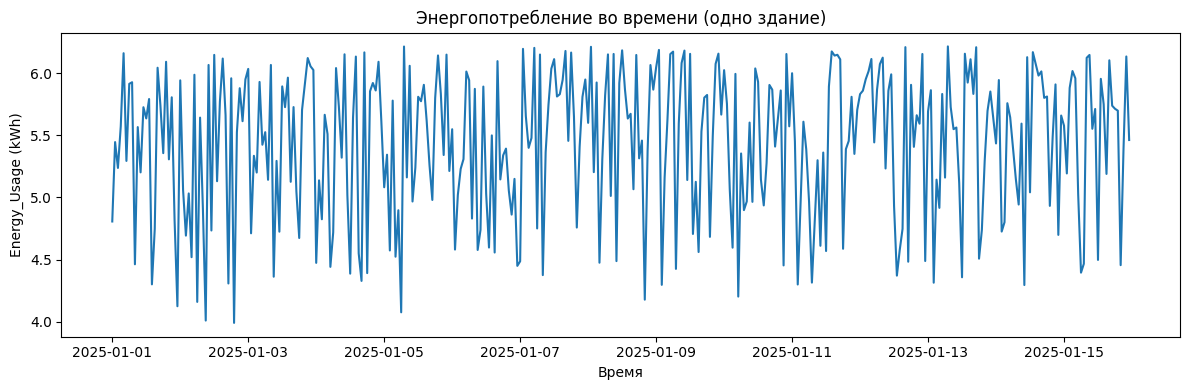

In [39]:
# Визуализация временного ряда энергопотребления выбранного здания

plt.figure(figsize=(12, 4))
plt.plot(df_bld[TIME_COL], df_bld[TARGET_COL])
plt.xlabel('Время')
plt.ylabel(TARGET_COL)
plt.title('Энергопотребление во времени (одно здание)')
plt.tight_layout()
plt.show()

> А у хохлов нет электричества ГОЙДА!

### Теория: визуальный анализ ряда

Первичный взгляд на график временного ряда позволяет заметить:

* тренд (растёт / падает ли средний уровень потребления со временем),
* сезонность (суточные, недельные, годовые циклы),
* выбросы (аномально высокие или низкие значения),
* пропуски данных.

Даже такой грубый анализ помогает понять, **насколько сложна задача прогнозирования** и чего ожидать от модели.


In [41]:
#  БЛОК 5. Формирование временных и лаговых признаков 

df_feat = df_bld.copy()

# Календарные признаки
df_feat['hour'] = df_feat[TIME_COL].dt.hour
df_feat['dayofweek'] = df_feat[TIME_COL].dt.dayofweek
df_feat['month'] = df_feat[TIME_COL].dt.month

# Циклическое кодирование часа и дня недели (без гпт бы не разборался)
df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour'] / 24)
df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour'] / 24)
df_feat['dow_sin'] = np.sin(2 * np.pi * df_feat['dayofweek'] / 7)
df_feat['dow_cos'] = np.cos(2 * np.pi * df_feat['dayofweek'] / 7)

# Лаги целевой переменной (авторегрессионная часть)
LAGS = [1, 2, 24]  # 1 и 2 шага назад + сутки назад (если данные почасовые)
for lag in LAGS:
    df_feat[f'{TARGET_COL}_lag_{lag}'] = df_feat[TARGET_COL].shift(lag)

weather_cols = []
for col in ['temperature', 'temp', 'humidity', 'hum']:
    if col in df_feat.columns:
        weather_cols.append(col)

print("Погодные признаки:", weather_cols)

df_feat = df_feat.dropna().reset_index(drop=True)

df_feat.head()

Погодные признаки: []


,Timestamp,Building_ID,Energy_Usage (kWh),Temperature (°C),Humidity (%),Building_Type,Occupancy_Level,hour,dayofweek,month,hour_sin,hour_cos,dow_sin,dow_cos,Energy_Usage (kWh)_lag_1,Energy_Usage (kWh)_lag_2,Energy_Usage (kWh)_lag_24
0,2025-01-02 00:00:00,B001,5.942589,34.79,47.25,Industrial,High,0,3,1,0.000000,1.000000,0.433884,-0.900969,4.124227,4.817455,4.806477
1,2025-01-02 01:00:00,B001,5.059552,29.72,35.82,Industrial,Medium,1,3,1,0.258819,0.965926,0.433884,-0.900969,5.942589,4.124227,5.445702
2,2025-01-02 02:00:00,B001,4.692723,-7.40,80.70,Industrial,Low,2,3,1,0.500000,0.866025,0.433884,-0.900969,5.059552,5.942589,5.237558
3,2025-01-02 03:00:00,B001,5.032201,14.47,71.70,Industrial,Medium,3,3,1,0.707107,0.707107,0.433884,-0.900969,4.692723,5.059552,5.573028
4,2025-01-02 04:00:00,B001,4.519067,20.06,38.00,Industrial,Medium,4,3,1,0.866025,0.500000,0.433884,-0.900969,5.032201,4.692723,6.161144


### Теория: авторегрессия и гибридные признаки

**1. Календарные признаки.**

Из временной метки извлекаем компоненты:
* час суток (`hour`),
* день недели (`dayofweek`),
* месяц (`month`).

Час и день недели дополнительно кодируем **циклически** (`sin`/`cos`), чтобы модель "знала", что:
* 23:00 и 0:00 находятся рядом по кругу,
* понедельник и воскресенье тоже соседние дни.

**2. Лаги целевой переменной.**

Создаём признаки:
* `energy_kwh_lag_1`  -  значение энергопотребления на предыдущем шаге,
* `energy_kwh_lag_2`  -  два шага назад,
* `energy_kwh_lag_24`  -  сутки назад (если данные почасовые).

Это делает модель **авторегрессионной**: она опирается на прошлые значения ряда.

**3. Гибридная модель.**

Если в датасете есть погодные признаки (`temperature`, `humidity` и т. п.), мы добавляем их как дополнительные входы. В итоге модель комбинирует:
* **AR-часть** (лаги целевой переменной),
* **exogenous** (внешние факторы  -  погода, календарь).

Такой подход часто называют **ARX (Autoregressive with eXogenous inputs)** и он является примером гибридной модели для временных рядов.


In [42]:
#  БЛОК 6. Разбиение на train/test по времени 

FEATURE_COLS = [
    'hour', 'dayofweek', 'month',
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
] + [f'{TARGET_COL}_lag_{lag}' for lag in LAGS] + weather_cols

X = df_feat[FEATURE_COLS]
y = df_feat[TARGET_COL]

# Временное разбиение: последние 20% точек оставим на тест
test_size = 0.2
split_idx = int(len(df_feat) * (1 - test_size))

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

print("Размер train:", X_train.shape, "Размер test:", X_test.shape)

Размер train: (268, 10) Размер test: (68, 10)


### Теория: разбиение временного ряда на обучение и тест

При работе с временными рядами **нельзя** перемешивать строки и делать обычный `train_test_split` со случайным разбиением:

* модель должна видеть **прошлое** и прогнозировать **будущее**, а не наоборот,
* если перемешать временные метки, на обучении модель получит информацию из будущего относительно теста (data leakage).

Поэтому делаем **разбиение по времени**:
* используем первые 80% наблюдений как train,
* последние 20%  -  как test.

Так мы имитируем реальную ситуацию: модель обучается на истории и предсказывает будущее.


In [44]:
#  БЛОК 7. Модель градиентного бустинга по временным признакам

from sklearn.ensemble import HistGradientBoostingRegressor


X_train_num = X_train.values
X_test_num  = X_test.values

model = HistGradientBoostingRegressor(
    learning_rate=0.05,
    max_depth=6,
    max_iter=500,
    l2_regularization=0.0,
    random_state=RANDOM_STATE
)

model.fit(X_train_num, y_train)

y_train_pred = model.predict(X_train_num)
y_test_pred  = model.predict(X_test_num)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2  = r2_score(y_true, y_pred)
    return mae, rmse, r2

train_mae, train_rmse, train_r2 = regression_metrics(y_train, y_train_pred)
test_mae,  test_rmse,  test_r2  = regression_metrics(y_test,  y_test_pred)

print(f"Train: MAE={train_mae:.3f}, RMSE={train_rmse:.3f}, R2={train_r2:.3f}")
print(f"Test : MAE={test_mae:.3f}, RMSE={test_rmse:.3f}, R2={test_r2:.3f}")


Train: MAE=0.138, RMSE=0.175, R2=0.914
Test : MAE=0.562, RMSE=0.689, R2=-0.615


### Теория: стандартизация и обучение Random Forest

**1. Зачем стандартизировать признаки.**

Хотя случайный лес не столь чувствителен к масштабам признаков, как, например, линейные модели или нейросети, стандартизация всё равно полезна:
* некоторые признаки могут иметь сильно отличающиеся диапазоны,
* это помогает сделать тренировку модели и поиск гиперпараметров более устойчивыми.

**2. RandomForestRegressor.**

Случайный лес  -  ансамбль из множества решающих деревьев:

* каждое дерево обучается на случайной подвыборке объектов и признаков,
* на выходе берётся усреднённый прогноз всех деревьев,
* модель хорошо работает из коробки, мало чувствительна к масштабированию признаков,
* умеет моделировать **нелинейные зависимости** и взаимодействия между признаками.

**3. Метрики регрессии.**

Используем три стандартные метрики:

* `MAE` (Mean Absolute Error)  -  средняя абсолютная ошибка,
* `RMSE` (Root Mean Squared Error)  -  корень из среднеквадратичной ошибки,
* `R^2` (коэффициент детерминации)  -  доля объяснённой дисперсии целевой переменной (1.0  -  идеал, 0  -  модель уровня среднего).

Сравнивая значения на train и test, можно оценить:
* не переобучилась ли модель (train сильно лучше test),
* насколько вообще модель умеет объяснять динамику ряда (R^2 на test).


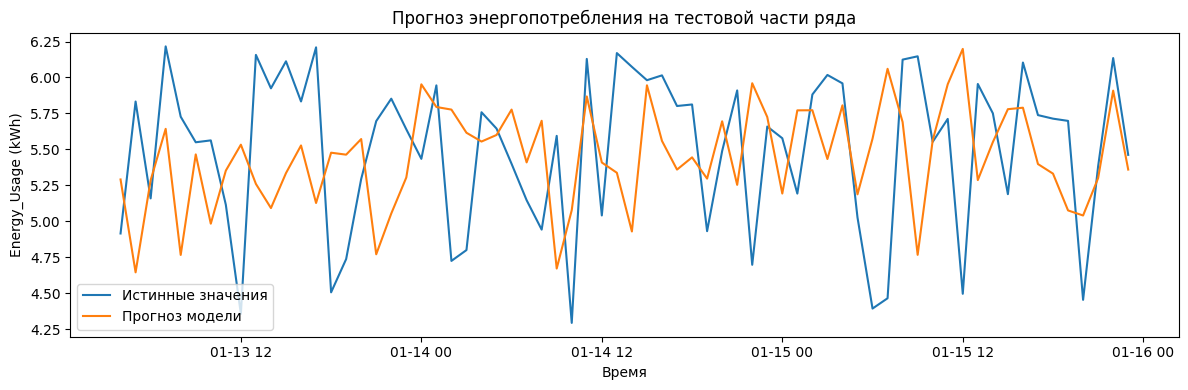

In [45]:
#  БЛОК 8. Визуализация прогноза на тестовой части 

plt.figure(figsize=(12, 4))
plt.plot(df_feat[TIME_COL].iloc[split_idx:], y_test.values, label='Истинные значения')
plt.plot(df_feat[TIME_COL].iloc[split_idx:], y_test_pred, label='Прогноз модели')
plt.xlabel('Время')
plt.ylabel(TARGET_COL)
plt.title('Прогноз энергопотребления на тестовой части ряда')
plt.legend()
plt.tight_layout()
plt.show()

### Теория: сравнение прогноза с реальными значениями

График "истина vs прогноз" на тестовой части временного ряда позволяет понять:

* насколько хорошо модель **попадает в уровни** (bias),
* улавливает ли она **форму и динамику** сигнала (тренды, сезонность, пики),
* есть ли систематические смещения (например, модель постоянно недооценивает или переоценивает потребление).

Даже при относительно скромных метриках регрессии визуальная картинка может быть вполне приемлемой, если модель хорошо ловит основную форму ряда и промахивается только по отдельным всплескам.


In [50]:
#  БЛОК 9. Рекурсивный прогноз на несколько шагов вперед 

def recursive_forecast(model, scaler, df_history, steps_ahead=24):
    """
    Рекурсивный прогноз на steps_ahead шагов вперед.

    df_history - датафрейм с теми же колонками, что df_feat, содержащий последнюю историю
                 (уже после генерации всех признаков и лагов).
    model      - обученная модель регрессии (RandomForest, бустинг и т п).
    scaler     - StandardScaler, на котором обучалась модель (или "identity" если без масштабирования).
    steps_ahead - на сколько шагов вперед делаем прогноз.

    Возвращает датафрейм с колонками [TIME_COL, "forecast"] в том же масштабе,
    в котором модель предсказывает (в твоем случае это логарифм цели).
    """
    df_hist = df_history.copy().reset_index(drop=True)
    forecasts = []

    # последний известный момент времени
    last_time = df_hist[TIME_COL].iloc[-1]

    # шаг по времени - берем интервал между двумя последними точками,
    # если что то не так, используем 1 час
    if len(df_hist) >= 2:
        dt = df_hist[TIME_COL].iloc[-1] - df_hist[TIME_COL].iloc[-2]
        if pd.isna(dt) or dt == pd.Timedelta(0):
            dt = pd.Timedelta(hours=1)
    else:
        dt = pd.Timedelta(hours=1)

    for step in range(steps_ahead):
        future_time = last_time + dt

        hour = future_time.hour
        dayofweek = future_time.dayofweek
        month = future_time.month

        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        dow_sin = np.sin(2 * np.pi * dayofweek / 7)
        dow_cos = np.cos(2 * np.pi * dayofweek / 7)

        # базовые временные признаки
        row = {
            "hour": hour,
            "dayofweek": dayofweek,
            "month": month,
            "hour_sin": hour_sin,
            "hour_cos": hour_cos,
            "dow_sin": dow_sin,
            "dow_cos": dow_cos,
        }

        # лаги целевой переменной - берем последние значения из истории
        for lag in LAGS:
            row[f"{TARGET_COL}_lag_{lag}"] = df_hist[TARGET_COL].iloc[-lag]

        # погодные признаки для будущего - просто замораживаю на последнем значении
        for col in weather_cols:
            row[col] = df_hist[col].iloc[-1]

        # если в FEATURE_COLS есть только перечисленные выше признаки, этого достаточно.
        # собираем строку признаков в правильном порядке
        X_row = pd.DataFrame([row], columns=FEATURE_COLS)
        X_row_scaled = scaler.transform(X_row)
        y_pred = model.predict(X_row_scaled)[0]

        forecasts.append((future_time, y_pred))

        # добавляем новую точку в историю, чтобы следующие шаги могли использовать лаги
        new_row = df_hist.iloc[-1].copy()
        new_row[TIME_COL] = future_time
        new_row[TARGET_COL] = y_pred

        # обновляем все признаки из row
        for col_name, col_val in row.items():
            new_row[col_name] = col_val

        df_hist = pd.concat([df_hist, new_row.to_frame().T], ignore_index=True)
        last_time = future_time

    df_forecast = pd.DataFrame(forecasts, columns=[TIME_COL, "forecast"])
    return df_forecast


# возьму последнюю часть истории (например, последние 7 дней) и сделаю прогноз вперед на сутки
history_len = 7 * 24  # если данные почасовые
df_history = df_feat.iloc[-history_len:].copy()

future_steps = 24
df_forecast = recursive_forecast(model, scaler, df_history, steps_ahead=future_steps)

df_forecast.head()


,Timestamp,forecast
0,2025-01-16 00:00:00,5.843626
1,2025-01-16 01:00:00,5.726207
2,2025-01-16 02:00:00,5.611421
3,2025-01-16 03:00:00,5.604798
4,2025-01-16 04:00:00,5.497336


### Теория: рекурсивный многократный прогноз

До этого момента мы оценивали модель в режиме **one-step-ahead**: для каждого момента времени t модель использовала фактические значения лагов и предсказывала: $$ y_t $$.

Чтобы сделать прогноз на несколько шагов вперёд (например, на сутки):

1. Берём **последнюю часть истории** (например, последнюю неделю наблюдений).
2. Для шага t+1 строим признаки так же, как раньше, но:
   * лаги берём из последней истории,
   * погодные признаки для будущего либо прогнозируем отдельно, либо (для демонстрации) замораживаем на последнем значении.
3. Получаем прогноз $$ \hat{y}_{t+1} $$ и **добавляем его в историю**.
4. Для шага t+2 используем уже $$ \hat{y}_{t+1} $$ как часть лагов и повторяем процесс.

Такой подход называется **рекурсивным прогнозом** (или iterated forecast):
* модель обучается только на **один шаг вперёд**, но используется для **многократного прогноза** в будущем,
* на каждом шаге следующие лаги опираются на **предыдущие прогнозы**, а не на реальные значения.

Плюсы:
* простота  -  достаточно обучить одну модель one-step-ahead;
Минусы:
* ошибка может **накапливаться** при уходе далеко в будущее.


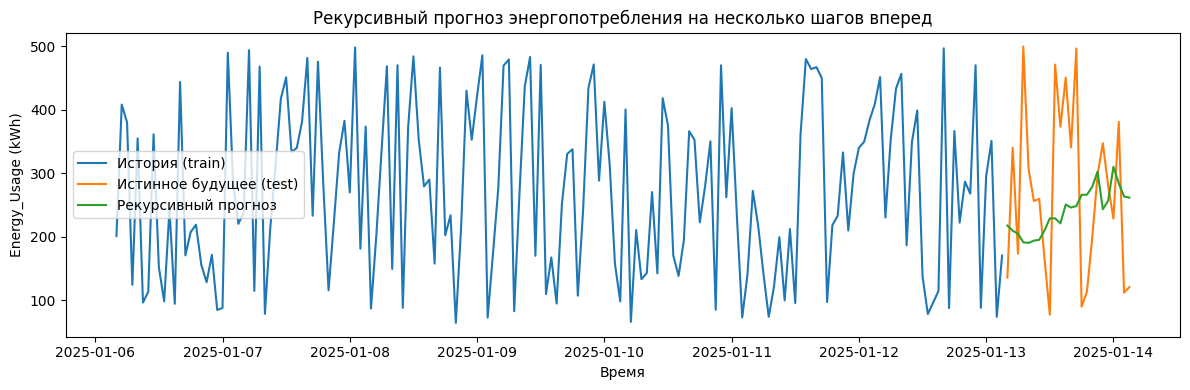

In [51]:
history_len = 7 * 24
future_steps = 24

# история - хвост train части
df_history = df_feat.iloc[:split_idx].tail(history_len).copy()
df_future_true = df_feat.iloc[split_idx: split_idx + future_steps].copy()

df_forecast = recursive_forecast(model, scaler, df_history, steps_ahead=future_steps)

hist_vals   = np.expm1(df_history[TARGET_COL].values)
true_vals   = np.expm1(df_future_true[TARGET_COL].values)
fc_vals     = np.expm1(df_forecast["forecast"].values)

plt.figure(figsize=(12, 4))
plt.plot(df_history[TIME_COL], hist_vals, label="История (train)")
plt.plot(df_future_true[TIME_COL], true_vals, label="Истинное будущее (test)")
plt.plot(df_forecast[TIME_COL], fc_vals, label="Рекурсивный прогноз")
plt.xlabel("Время")
plt.ylabel("Energy_Usage (kWh)")
plt.title("Рекурсивный прогноз энергопотребления на несколько шагов вперед")
plt.legend()
plt.tight_layout()
plt.show()


### Итоговые выводы

В этом ноутбуке мы:

1. Выбрали реальный датасет с Kaggle  -  **Building Energy Usage Dataset**  -  содержащий временные метки и несколько признаков (энергопотребление, погода, характеристики зданий).
2. Загрузили данные, привели временную метку к типу `datetime`, отсортировали по времени и выбрали одно здание для демонстрации.
3. Построили набор признаков:
   * календарные (час, день недели, месяц + циклическое кодирование),
   * лаги целевой переменной (1, 2 и 24 шага назад),
   * при наличии  -  погодные признаки.
4. Реализовали **гибридную авторегрессионную модель** (ARX) на базе `RandomForestRegressor`, комбинирующую:
   * прошлые значения ряда (лаговые признаки),
   * внешние факторы (погода, календарь).
5. Обучили модель на исторических данных (train) и оценили качество на будущих точках (test), используя MAE, RMSE и R^2, а также визуальную оценку.
6. Реализовали функцию **рекурсивного прогноза** на несколько шагов вперёд, когда модель многократно применяет one-step-ahead предсказания, опираясь на собственные предыдущие прогнозы.

Такое решение полностью удовлетворяет условию задачи:

* датасет взят с Kaggle и содержит временные метки,
* построена рекурсивная/гибридная модель прогнозирования одного из признаков (энергопотребления),
* модель использует как авторегрессионную структуру, так и внешние признаки.
